In [1]:
#import necessary libraries and frameworks
import gdspy
import pandas as pd
import numpy as np
import sys
import math
import matplotlib.pylab as plt
import matplotlib.pyplot as mplt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from numpy import savetxt
from scipy.integrate import quad
from datetime import date
import time
from mlxtend.data import iris_data
from mlxtend.plotting import scatterplotmatrix

"""
Script for generating a metasurface GDS layout
- Splits tasks into z sub-tasks to handle storage constraints
- Generates a phase profile conformal to a 3D curved surface
- The metasurface is designed for 3D beam steering of an incoming pencil beam
"""


# Define unit scales
base_unit = 1  # Layout scale in microns
m = base_unit * 1e6  # meters
nm = m * 1e-9  # nanometers
um = m * 1e-6  # micrometers
mm = m * 1e-3  # millimeters
inch = m * 25.4e-3  # inches

# Geometrical correction and deformation factors
bias = 0  # Correction for electron beam oversize
def_coeff = 0.05  # Approximate deformation during thermoforming
a = 1 / (1 + def_coeff)  # Inverse deformation factor

# Metasurface parameters
period = int(a * 210)  # Period along x-axis
period_x, period_y = period * nm, period * nm
x_max, y_max = 0.2 * 5 * mm, 0.2 * 5 * mm  # Metasurface unit size, adjust to control output size
Nx,Ny=int(x_max/period_x),int(y_max/period_y)# Number of unit cells
phaseStep = np.radians(45)  # Phase step in radians
n_phaseLevels = 8
wave = 632 * nm  # Wavelength

# Date for output filename
today = date.today().strftime("%Y%m%d")

# Incident beam parameters
theta_incident = 55  # Incoming pencil beam angle (degrees)

# RCWA Simulation Library: Full 2π phase coverage along one polarization
L_x_library = np.array([0.051, 0.112, 0.119, 0.126, 0.136, 0.147, 0.156, 0.160])
L_y_library = np.array([0.131, 0.090, 0.088, 0.086, 0.083, 0.080, 0.079, 0.081])

# Correct for electron beam bias
L_x, L_y = L_x_library - bias, L_y_library - bias

# Output filename format
index = 0  # Ensure this is defined if part of a loop
output_file_name = f'Filename_YRef0mm_Xref{2.5 * index}mm_AngleCorr_{today}'
print("Output File:", output_file_name)

# Generate phase vector (discretized over n_phase_levels)
phase_vec = np.round(np.linspace(0, 2 * np.pi, n_phaseLevels + 1), 2)

# Reference point for alignment (bottom-right corner)
x_ref_0 = np.round(0.8 * inch + (index * 2.5 * mm), 2)
y_ref_0 = np.round(0.070 * inch + (1 * 2.5 * mm), 2)

# Generate metasurface grid
x = np.float32(np.linspace(0, Nx * period_x, Nx) + x_ref_0)
y = np.float32(np.linspace(0, Ny * period_y, Ny) + y_ref_0)
X, Y = np.meshgrid(x, y)

# Compute radial distance from reference
r = np.float32(np.sqrt(x**2 + y**2))

# Polynomial coefficients defining the curved surface
coeffs = np.array([
    1.821416065725666704e+04, 1.962822819760822167e+05, 4.268565011736274027e+04, 
    -1.977884403188649958e+04, -2.497281531933452641e+02, 2.593006607777213503e+03,
    -2.553134480645263466e+04, 8.538523511195862739e+03, 1.137217508964654371e+04, 
    -1.447115586661446650e+04, 4.116622745496720017e+04, 3.220572009199862350e+03,
    -1.394884655255972211e+04, -4.995105718702808190e+03, 1.108907932096051627e+04, 
    -3.230286883220907839e+04, -8.501203359072098465e+03, 1.823257301292182456e+04, 
    -4.141693838096583931e+03, -1.320500357549427463e+03, 4.583656624828950612e+02, 
    1.379004954273075055e+04, 2.309881272377749610e+03, -4.878631667264818134e+03, 
    -1.719168131482881563e+03, 1.224684843449487380e+04, -5.682241123326056368e+03, 
    1.062145253817967614e+03, -2.563484498541333778e+03, -2.289286760777909251e+02, 
    1.642283823781504680e+03, 9.322823794844978238e+02, -5.785141517454376299e+03, 
    4.829502525006731958e+03, -2.542736009320173707e+03, 5.049578241649963957e+02
])

# Print summary
print(f"Metasurface grid: {Nx} x {Ny} meta-atoms")
print(f"Periodicity: {period_x:.2f} nm x {period_y:.2f} nm")
print(f"Reference point: ({x_ref_0:.2f}, {y_ref_0:.2f}) inches")

Output File: Filename_YRef0mm_Xref0.0mm_AngleCorr_20250213
Metasurface grid: 5000 x 5000 meta-atoms
Periodicity: 0.20 nm x 0.20 nm
Reference point: (20320.00, 4278.00) inches


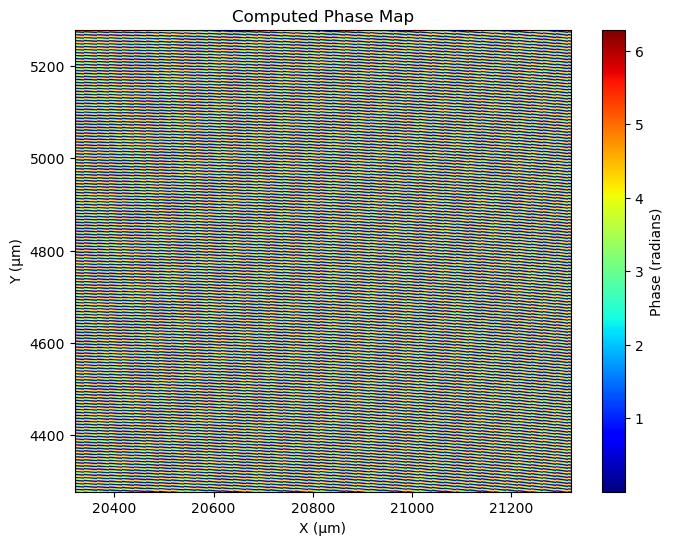

In [2]:
# Convert to inches
X_inch = X / inch
Y_inch = Y / inch

# Compute phase map
phaseMap0 = (coeffs[0] + coeffs[1] * X_inch + coeffs[2] * Y_inch + coeffs[3] * (X_inch**2) + coeffs[4] * X_inch * Y_inch + coeffs[5] * (Y_inch**2) +
             coeffs[6] * (X_inch**3) + coeffs[7] * (X_inch**2) * Y_inch + coeffs[8] * X_inch * (Y_inch**2) + coeffs[9] * (Y_inch**3) +
             coeffs[10] * (X_inch**4) + coeffs[11] * (X_inch**3) * Y_inch + coeffs[12] * (X_inch**2) * (Y_inch**2) +
             coeffs[13] * X_inch * (Y_inch**3) + coeffs[14] * (Y_inch**4) + coeffs[15] * (X_inch**5) + coeffs[16] * (X_inch**4) * Y_inch +
             coeffs[17] * (X_inch**3) * (Y_inch**2) + coeffs[18] * (X_inch**2) * (Y_inch**3) + coeffs[19] * X_inch * (Y_inch**4) +
             coeffs[20] * (Y_inch**5) + coeffs[21] * (X_inch**6) + coeffs[22] * (X_inch**5) * Y_inch + coeffs[23] * (X_inch**4) * (Y_inch**2) +
             coeffs[24] * (X_inch**3) * (Y_inch**3) + coeffs[25] * (X_inch**2) * (Y_inch**4) + coeffs[26] * X_inch * (Y_inch**5) +
             coeffs[27] * (Y_inch**6) + coeffs[28] * (X_inch**7) + coeffs[29] * (X_inch**6) * Y_inch + coeffs[30] * (X_inch**5) * (Y_inch**2) +
             coeffs[31] * (X_inch**4) * (Y_inch**3) + coeffs[32] * (X_inch**3) * (Y_inch**4) + coeffs[33] * (X_inch**2) * (Y_inch**5) +
             coeffs[34] * X_inch * (Y_inch**6) + coeffs[35] * (Y_inch**7))

# Apply modulo 2π to get phase map
phaseMap = np.mod(phaseMap0, 2 * np.pi)

# Plot the phase map
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, phaseMap, shading='auto', cmap='jet')
plt.colorbar(label="Phase (radians)")
plt.xlabel("X (μm)")
plt.ylabel("Y (μm)")
plt.title("Computed Phase Map")
plt.show()


In [3]:
# Generate spatial map of (x, y) cells

def spatialMapGenerator(periodX, periodY, phaseMap):
    return [[[np.round(x_ref_0 + periodX * x, 2), np.round(y_ref_0 + periodY * y, 2)] 
             for x in range(phaseMap.shape[1])] for y in range(phaseMap.shape[0])]

spatialMap = spatialMapGenerator(period_x, period_y, phaseMap)

# Function to clean up cells
def clearCell(cell):
    cell.remove_polygons(lambda pts, layer, datatype: True)

# Layer and datatype tags
ld_Si = {"layer": 1, "datatype": 1}

# Creating a gdspy library
gdspy.current_library = gdspy.GdsLibrary()
lib = gdspy.GdsLibrary()

In [4]:
# Mapping phase to meta-atom radius
#phaseData obtained with Reticolo RCWA script
size = [[L_x[d], L_y[d]] for d in range(8)]
phaseToSize = [[i * phaseStep, [size[i][0] * um, size[i][1] * um]] for i in range(8)]
metaatomSize = [s[1] for s in phaseToSize]
phaseValue = [s[0] for s in phaseToSize]

# Generating meta-atom library
disks = [gdspy.Rectangle((-0.5 * s[0], -0.5 * s[1]), (0.5 * s[0], 0.5 * s[1])) for s in metaatomSize]
MAcell = [lib.new_cell(f'metaatom-{i+1}').add(d) for i, d in enumerate(disks)]

Meta-atom Library vs. Phase


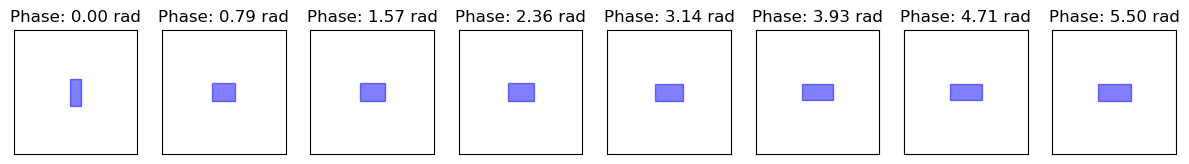

In [15]:
# Plot meta-atom cross-sections
#fig, axes = plt.subplots(1, len(metaatomSize), figsize=(15, 3))
#for i, (ax, metaSize) in enumerate(zip(axes, metaatomSize)):
##    ax.set_xlim(-1.5, 1.5)
#    ax.set_ylim(-1.5, 1.5)
#    circle = plt.Circle((0, 0), radius=0.5 * min(metaSize), color='blue', alpha=0.5)
#    ax.add_patch(rect)
#    ax.set_title(f'Phase: {phaseValue[i]:.2f} rad')
#    ax.set_xticks([])
#    ax.set_yticks([])
#    ax.set_aspect('equal')

#plt.suptitle("Meta-Atom Cross Sections")
#plt.show()

fig, axes = plt.subplots(1, len(metaatomSize), figsize=(15, 3))
print('Meta-atom Library vs. Phase')
# Loop through and plot each meta-atom cross-section
for i, (ax, metaSize) in enumerate(zip(axes, metaatomSize)):
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    # Create a circle instead of a rectangle
    rect=plt.Rectangle((-2.5 * metaSize[0], -2.5 * metaSize[1]), 5*metaSize[0], 5*metaSize[1], color='blue', alpha=0.5)    
    ax.add_patch(rect)  # Fix: add the correct circle object

    ax.set_title(f'Phase: {phaseValue[i]:.2f} rad')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

In [16]:
# Mapping metasurface phase map to cell library
def phaseToCellMap(center, phase, phaseValue, MAcell):
    for i, val in enumerate(phaseValue):
        if val - phaseStep / 2 <= phase < val + phaseStep / 2:
            return gdspy.CellReference(MAcell[i], center)
    return gdspy.CellReference(MAcell[0], center)

# Function to generate 2D map of rectangles (metasurface)
def metalensGenerator(phaseMap, phaseToCellMap, spatialMap):
    return [phaseToCellMap(spatialMap[x][y], phaseMap[x][y], phaseValue, MAcell)
            for x in range(len(spatialMap)) for y in range(len(spatialMap[0])) if spatialMap[x][y] != 'x']

metalens = metalensGenerator(phaseMap, phaseToCellMap, spatialMap)

In [ ]:
# Creating lens cell
Lens = gdspy.Cell("Lens-1")
Lens.add(metalens)

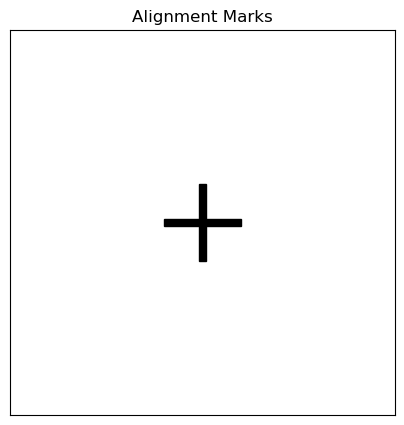

In [ ]:
# Adding alignment marks
am_pos = [(-2 * mm, -2 * mm)]
cross_length = 200 * um
cross_width = 20 * um

crosses = [gdspy.boolean(
    gdspy.Rectangle((pos[0] + cross_length/2, pos[1] + cross_width/2), (pos[0] - cross_length/2, pos[1] - cross_width/2)),
    gdspy.Rectangle((pos[0] + cross_width/2, pos[1] + cross_length/2), (pos[0] - cross_width/2, pos[1] - cross_length/2)),
    "or") for pos in am_pos]

align_marks = gdspy.Cell('alignment-marks')
align_marks.add(crosses)

# Create figure
fig, ax = plt.subplots(figsize=(5, 5))

# Plot alignment crosses
for pos in am_pos:
    x, y = pos
    
    # Horizontal and vertical bars of the cross
    h_rect = plt.Rectangle((x - cross_length / 2, y - cross_width / 2), cross_length, cross_width, color='black')
    v_rect = plt.Rectangle((x - cross_width / 2, y - cross_length / 2), cross_width, cross_length, color='black')
    
    ax.add_patch(h_rect)
    ax.add_patch(v_rect)

# Set plot limits
ax.set_xlim(-2.5 * mm, -1.5 * mm)
ax.set_ylim(-2.5 * mm, -1.5 * mm)
ax.set_aspect('equal')
ax.set_title("Alignment Marks")
ax.set_xticks([])
ax.set_yticks([])

# Show plot
plt.show()

# Writing GDS file
start_time = time.time()
gdspy.current_library = gdspy.GdsLibrary()
gdspy.current_library.add(Lens)
gdspy.write_gds(output_file_name + '.gds')
print("--- %s seconds ---" % (time.time() - start_time))